In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from category_encoders import TargetEncoder
import shap
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.options.display.max_columns = 200


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Load the raw chart dataset
DATA_PATH = 'Spotify_Dataset_V3_All_Clusters_v2.csv' # adjust filename as needed
df = pd.read_csv(DATA_PATH)
df['Date_parsed'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date_parsed'])
df['year_week'] = df['Date_parsed'].dt.isocalendar().year.astype(str) + '-W' + df['Date_parsed'].dt.isocalendar().week.astype(str)
agg = df.groupby('id').agg(
    weeks_in_top200=('year_week', 'nunique'),
    first_chart_date=('Date_parsed', 'min'),
    last_chart_date=('Date_parsed', 'max'),
    observed_days=('Date_parsed', 'size'),
    initial_rank=('Rank', 'min'),
    max_rank=('Rank', 'max'),
    points_total=('Points (Total)', 'max')
).reset_index()


Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


In [3]:
# Song age & season
agg['song_year'] = agg['first_chart_date'].dt.year
agg['song_month'] = agg['first_chart_date'].dt.month
agg['song_season'] = agg['song_month']%12 // 3 + 1 # 1=Winter, 2=Spring, 3=Summer, 4=Fall

# Popularity trajectory
agg['rank_slope'] = (agg['max_rank'] - agg['initial_rank']) / agg['weeks_in_top200']

# Join cluster and label features from one example row per song, merge on id
meta_cols = ['Sonic_Cluster_Label', 'Artist_Tier_Label', 'Temporal_Cluster_Name',
             'Performance_Cluster_Name', 'Collab_Cluster_Name', 'Geo_Cluster_Name', 'Evo_Cluster_Name']
numeric_cols = ['Danceability','Energy','Loudness','Speechiness','Acousticness','Instrumentalness','Valence','Points (Total)']
data_sample = df.groupby('id').first().reset_index()
agg = agg.merge(data_sample[['id'] + meta_cols + numeric_cols + ['Artists']], on='id')

# Artist count from name field (comma separated)
agg['artist_count'] = agg['Artists'].fillna('').apply(lambda x: len(str(x).split(',')))

# Superstar indicator from Artist_Tier_Label
agg['superstar'] = (agg['Artist_Tier_Label'] == 'Superstars').astype(int)


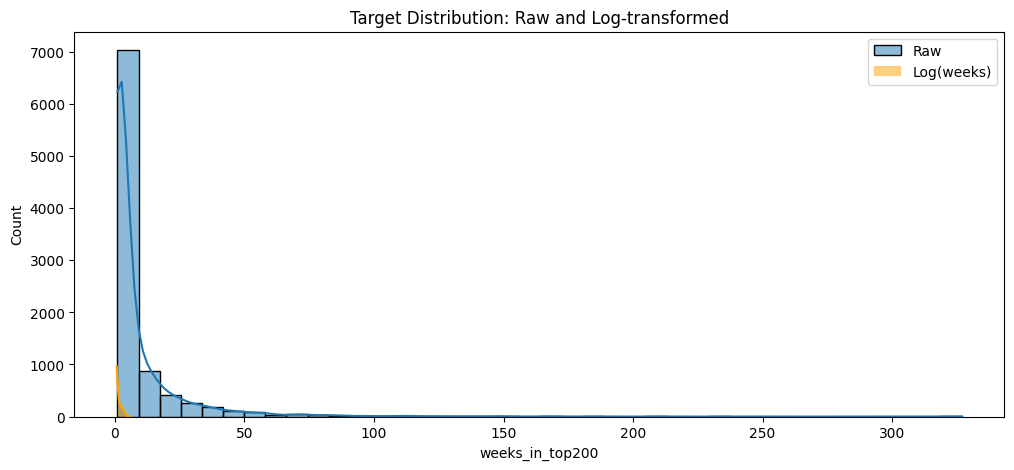

Target skewness: 6.11109595604994 After log: 1.0880782280526753


In [4]:
agg = agg.dropna(subset=['weeks_in_top200'])
agg['weeks_log'] = np.log1p(agg['weeks_in_top200'])
plt.figure(figsize=(12,5))
sns.histplot(agg['weeks_in_top200'], bins=40, kde=True, label='Raw');
sns.histplot(agg['weeks_log'], bins=40, kde=True, label='Log(weeks)', color='orange');
plt.legend(); plt.title('Target Distribution: Raw and Log-transformed'); plt.show()
print('Target skewness:', agg['weeks_in_top200'].skew(), 'After log:', agg['weeks_log'].skew())


In [5]:
feature_cols = numeric_cols + [
    'song_year', 'song_month', 'song_season', 'rank_slope', 'artist_count', 'superstar',
    'Sonic_Cluster_Label', 'Artist_Tier_Label', 'Temporal_Cluster_Name',
    'Performance_Cluster_Name', 'Collab_Cluster_Name', 'Geo_Cluster_Name', 'Evo_Cluster_Name'
]
cat_feats = [c for c in feature_cols if agg[c].dtype == 'object' or agg[c].dtype.name == 'category']
num_feats = [c for c in feature_cols if c not in cat_feats]
X = agg[feature_cols]
y = agg['weeks_log']
dates = agg['first_chart_date']

# Temporal train-test split
unique_dates = np.array(sorted(agg['first_chart_date'].unique()))
cutoff_index = int(len(unique_dates) * 0.8)
cutoff_date = unique_dates[cutoff_index]
train_mask = agg['first_chart_date'] <= cutoff_date
test_mask = agg['first_chart_date'] > cutoff_date
X_train = X[train_mask].reset_index(drop=True)
y_train = y[train_mask].reset_index(drop=True)
X_test = X[test_mask].reset_index(drop=True)
y_test = y[test_mask].reset_index(drop=True)


In [6]:
low_card = [c for c in cat_feats if X_train[c].nunique() <= 8]
high_card = [c for c in cat_feats if X_train[c].nunique() > 8]
main_preproc = ColumnTransformer([
    ('num', Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler())]), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), low_card)
])
if high_card:
    te = TargetEncoder(cols=high_card, smoothing=0.30)
    X_train_te = te.fit_transform(X_train, y_train)
    X_test_te = te.transform(X_test)
    X_train_final = pd.DataFrame(main_preproc.fit_transform(X_train_te))
    X_test_final = pd.DataFrame(main_preproc.transform(X_test_te))
else:
    X_train_final = pd.DataFrame(main_preproc.fit_transform(X_train))
    X_test_final = pd.DataFrame(main_preproc.transform(X_test))


In [7]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=5)
lgb = LGBMRegressor(random_state=RANDOM_STATE)
lgb_grid = {'num_leaves':[31,63],'learning_rate':[0.03,0.1],'n_estimators':[100,300],'max_depth':[6,12],'subsample':[0.8,1.0]}
gs = GridSearchCV(lgb, lgb_grid, scoring='neg_mean_squared_error', cv=cv, verbose=2, n_jobs=-1)
gs.fit(X_train_final, y_train)
lgb_best = gs.best_estimator_
print('Best LGBM params:', gs.best_params_)

rf = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train_final, y_train)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2251
[LightGBM] [Info] Number of data points in the train set: 7752, number of used features: 48
[LightGBM] [Info] Start training from score 1.626840
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best LGBM params: {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 300, 'num_leaves': 31, 'subsample': 0.8}


RandomForestRegressor(max_depth=10, n_estimators=300, n_jobs=-1,
                      random_state=42)

In [8]:
def eval_reg(y_true, y_pred, name):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'{name}: RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}')
    return {'rmse':rmse,'mae':mae,'r2':r2}

# Predictions for each candidate model (log-space)
y_pred_lgb = lgb_best.predict(X_test_final)
y_pred_rf = rf.predict(X_test_final)

# Evaluate on log-target
metrics_lgb = eval_reg(y_test, y_pred_lgb, 'LGBM')
metrics_rf  = eval_reg(y_test, y_pred_rf, 'RandomForest')

# Choose best model by RMSE on log-target (change criterion if you prefer)
if metrics_rf['rmse'] <= metrics_lgb['rmse']:
    best_model = rf
    best_pred = y_pred_rf
    print("Selected best model: RandomForest")
else:
    best_model = lgb_best
    best_pred = y_pred_lgb
    print("Selected best model: LGBM")

# Also show performance back-transformed to weeks for interpretability
y_test_weeks = np.expm1(y_test)
y_pred_best_weeks = np.expm1(best_pred)
eval_reg(y_test_weeks, y_pred_best_weeks, f'BestModel (back-transformed weeks)')

LGBM: RMSE=0.308, MAE=0.186, R²=0.888
RandomForest: RMSE=0.344, MAE=0.193, R²=0.861
Selected best model: LGBM
BestModel (back-transformed weeks): RMSE=5.347, MAE=1.906, R²=0.716


{'rmse': 5.347431973628117,
 'mae': 1.9064459439602381,
 'r2': 0.7163254041820648}

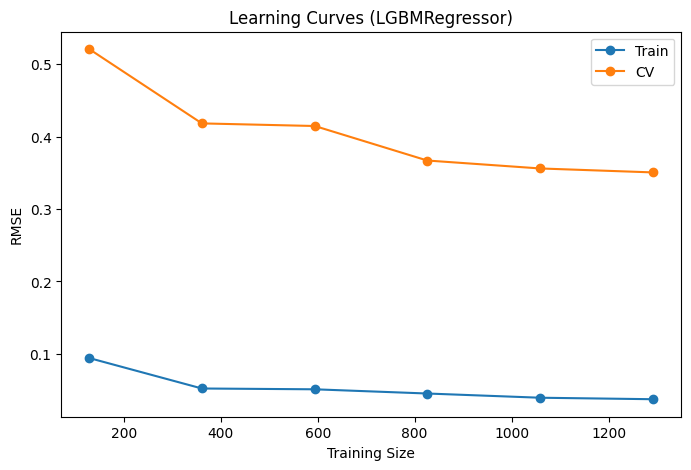

In [10]:
# Learning curve for the chosen best_model
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_final, y_train,
    train_sizes=np.linspace(0.1,1.0,6), cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_root_mean_squared_error', n_jobs=-1)
train_scores = -np.array(train_scores)
test_scores = -np.array(test_scores)
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores.mean(axis=1), '-o', label='Train')
plt.plot(train_sizes, test_scores.mean(axis=1), '-o', label='CV')
plt.xlabel('Training Size'); plt.ylabel('RMSE'); plt.legend();
plt.title(f'Learning Curves ({best_model.__class__.__name__})'); plt.show()

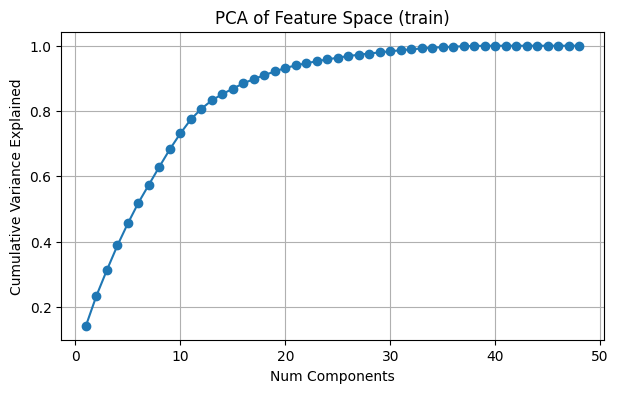

In [11]:
pca = PCA().fit(X_train_final)
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(7,4))
plt.plot(range(1,len(cum_var)+1), cum_var, marker='o')
plt.xlabel('Num Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('PCA of Feature Space (train)')
plt.grid(True);
plt.show()


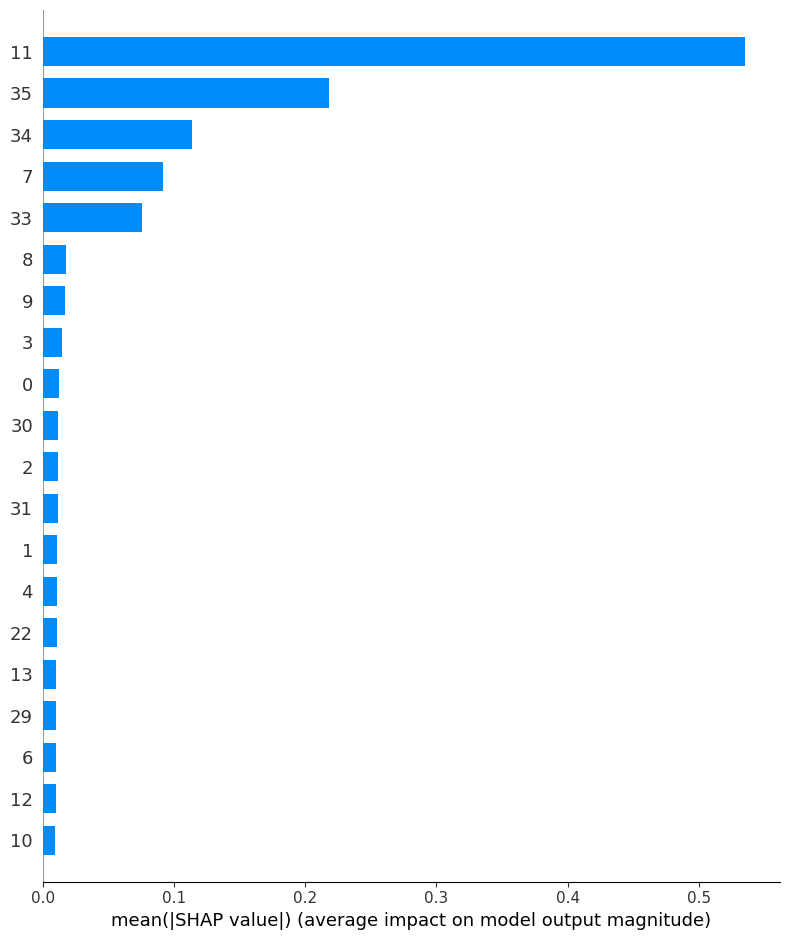

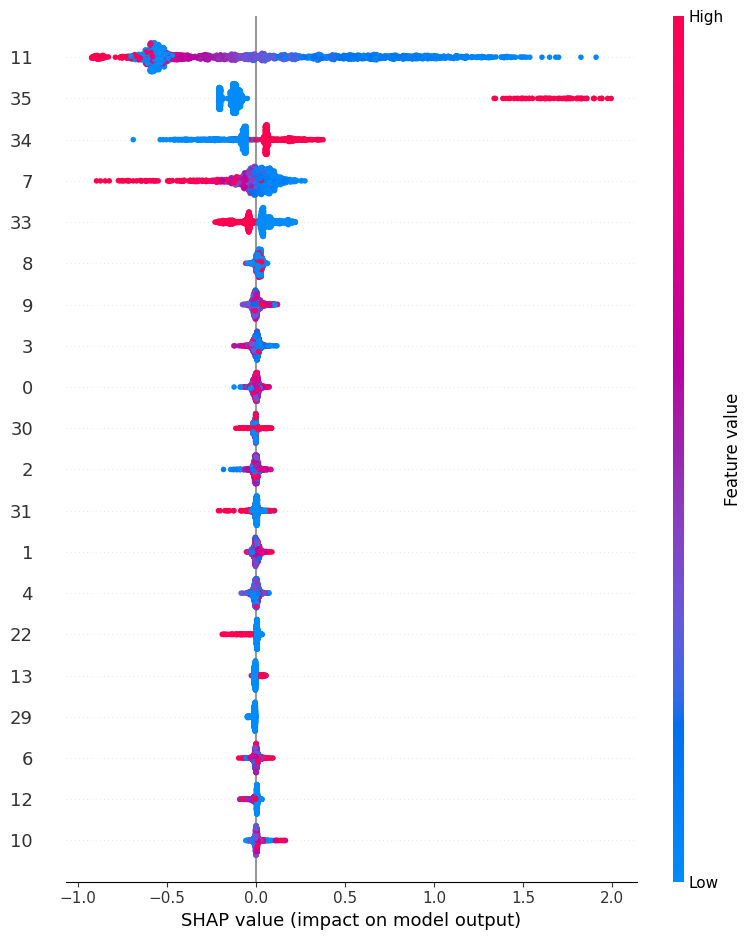

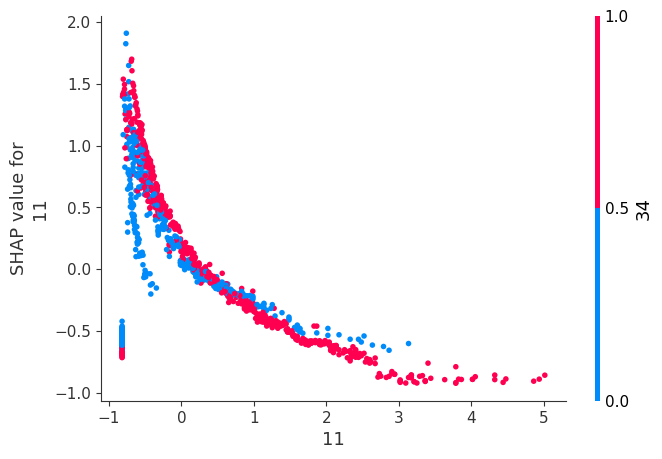

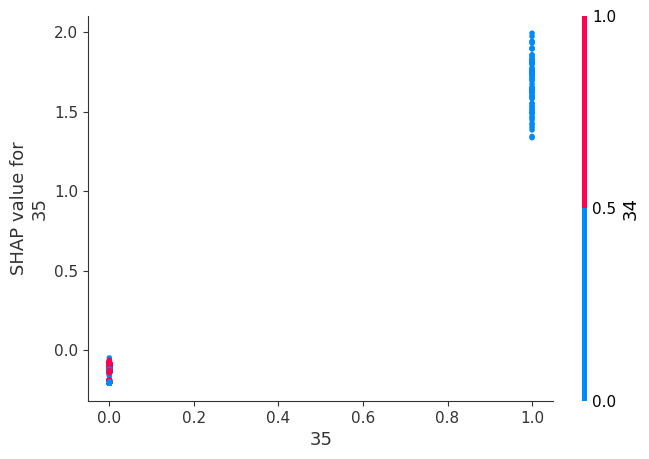

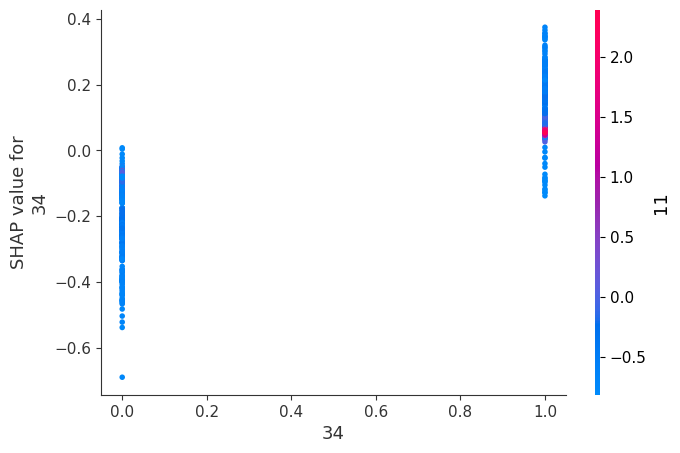

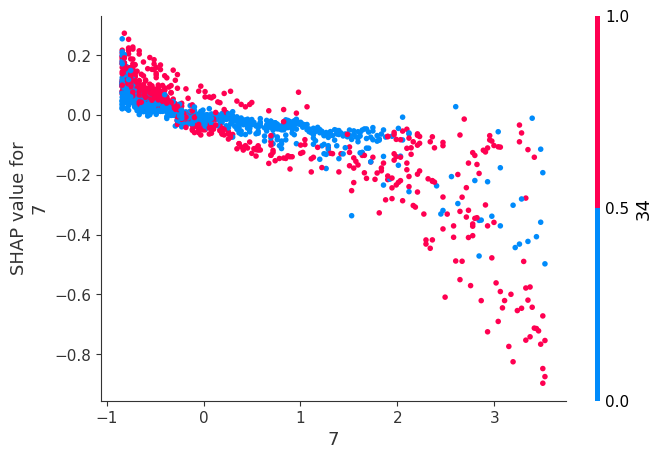

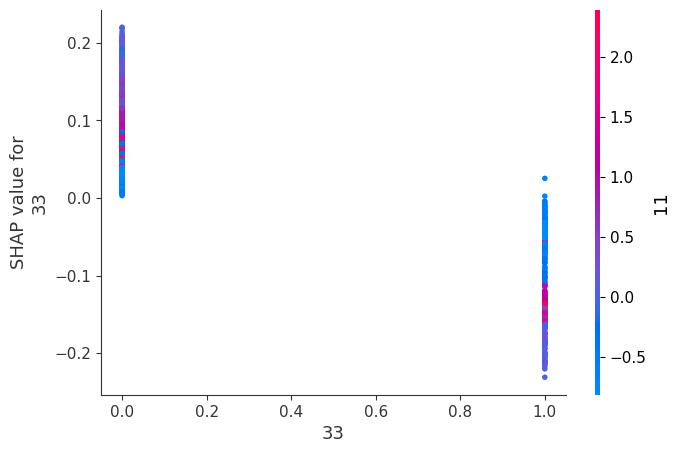

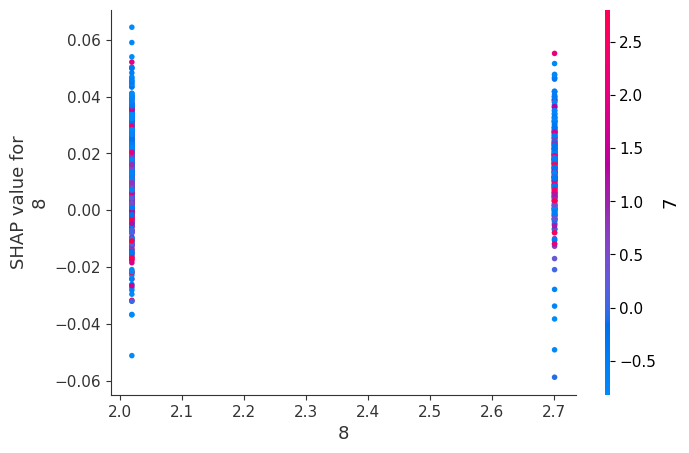

In [12]:
# SHAP for the chosen best_model
shap.initjs()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_final)
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_test_final, plot_type="bar")
shap.summary_plot(shap_values, X_test_final)
# For top features (works for either RF or LGB)
top_feats = np.argsort(np.abs(shap_values).mean(axis=0))[-6:][::-1]
for i in top_feats:
    fname = X_test_final.columns[i] if hasattr(X_test_final, 'columns') else f'f_{i}'
    shap.dependence_plot(i, shap_values, X_test_final, feature_names=X_test_final.columns)

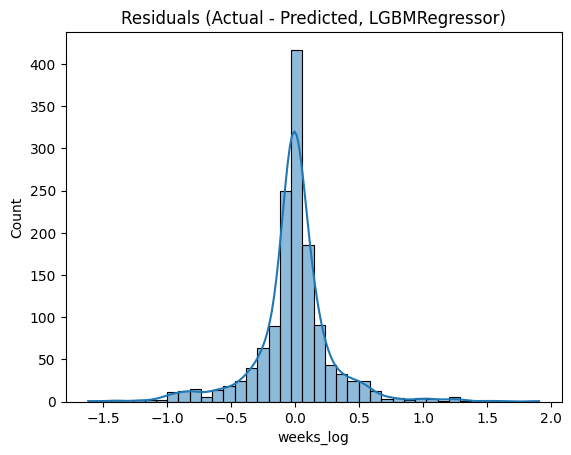

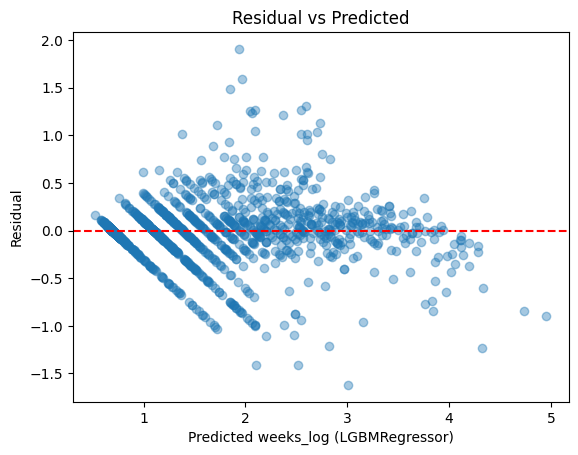

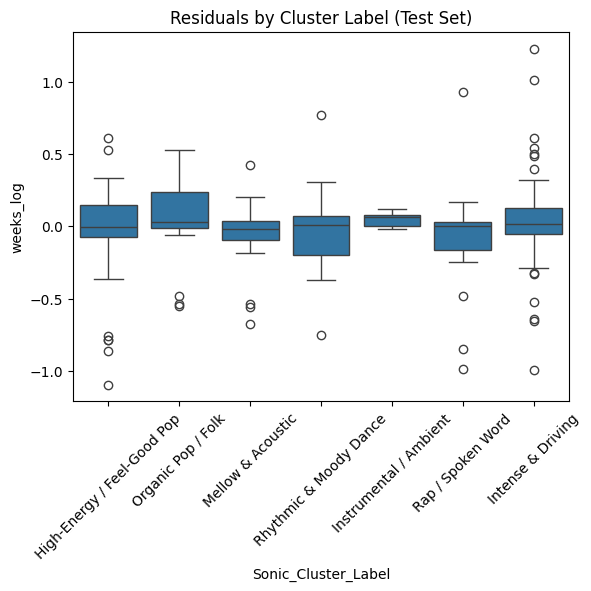

In [13]:
# Residual analysis using best model predictions (log space)
residuals = y_test - best_pred
sns.histplot(residuals, bins=40, kde=True)
plt.title(f'Residuals (Actual - Predicted, {best_model.__class__.__name__})'); plt.show()
plt.scatter(best_pred, residuals, alpha=0.4)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel(f'Predicted weeks_log ({best_model.__class__.__name__})'); plt.ylabel('Residual'); plt.title('Residual vs Predicted'); plt.show()
# By main meta feature (example: Sonic_Cluster_Label on test set)
meta_label = agg.loc[test_mask, 'Sonic_Cluster_Label']
sns.boxplot(x=meta_label, y=residuals)
plt.title('Residuals by Cluster Label (Test Set)'); plt.xticks(rotation=45); plt.show()

In [14]:
# Single-song prediction & explanation using best_model
song_idx = 210  # Change as needed
new_song = X_test.iloc[[song_idx]].copy()
true_weeks = agg.loc[test_mask].iloc[song_idx]['weeks_in_top200']

# Encode features as in training
if 'te' in globals() and te is not None and hasattr(te, 'transform'):
    new_song_encoded = te.transform(new_song)
else:
    new_song_encoded = new_song.copy()
new_song_final = pd.DataFrame(main_preproc.transform(new_song_encoded))

# Predict log weeks, reverse transformation using best_model
pred_log = best_model.predict(new_song_final)[0]
pred_weeks = np.expm1(pred_log)

print(f"\nTrue weeks in top 200: {true_weeks}")
print(f"Predicted weeks in top 200: {round(pred_weeks,1)}")

# SHAP explanation using best_model
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(new_song_final)
# shap_values may be a 2D array for single sample; select correct row if needed
sv = shap_values[0] if hasattr(shap_values, "__len__") and np.array(shap_values).ndim > 1 else shap_values
base_value = explainer.expected_value

# Build contributions table
feature_names = new_song_final.columns if hasattr(new_song_final, 'columns') else [f"f_{i}" for i in range(new_song_final.shape[1])]
contrib = pd.DataFrame({
    'feature': feature_names,
    'shap_value': sv,
    'input_value': new_song_final.iloc[0].values
}).sort_values(by='shap_value', key=np.abs, ascending=False)

print("\nTop features affecting prediction:")
for i, row in contrib.head(10).iterrows():
    effect = "pushes UP" if row['shap_value'] > 0 else "pulls DOWN"
    print(f"- {row['feature']}: value={row['input_value']} {effect} by {row['shap_value']:.2f} log-weeks")

# Force plot
shap.initjs()
shap.force_plot(base_value, sv, new_song_final, feature_names=list(feature_names))


True weeks in top 200: 1
Predicted weeks in top 200: 1.0

Top features affecting prediction:
- 11.0: value=-0.8177785404392698 pulls DOWN by -0.53 log-weeks
- 35.0: value=0.0 pulls DOWN by -0.20 log-weeks
- 34.0: value=0.0 pulls DOWN by -0.08 log-weeks
- 32.0: value=1.0 pulls DOWN by -0.04 log-weeks
- 33.0: value=0.0 pushes UP by 0.04 log-weeks
- 7.0: value=0.93599787039485 pulls DOWN by -0.02 log-weeks
- 9.0: value=-0.7021310362589971 pulls DOWN by -0.02 log-weeks
- 12.0: value=4.907444792964098 pulls DOWN by -0.01 log-weeks
- 29.0: value=0.0 pulls DOWN by -0.01 log-weeks
- 3.0: value=1.342330959478535 pulls DOWN by -0.01 log-weeks
